In [25]:
import pandas as pd
import re
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import torch
from xgboost import set_config
import cupy as cp

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#### Importing the train csv file contaning the quesitons

In [32]:
df = pd.read_csv('data/train.csv')

In [33]:
print(df.head)

<bound method NDFrame.head of             id    qid1    qid2  \
0            0       1       2   
1            1       3       4   
2            2       5       6   
3            3       7       8   
4            4       9      10   
...        ...     ...     ...   
404285  404285  433578  379845   
404286  404286   18840  155606   
404287  404287  537928  537929   
404288  404288  537930  537931   
404289  404289  537932  537933   

                                                question1  \
0       What is the step by step guide to invest in sh...   
1       What is the story of Kohinoor (Koh-i-Noor) Dia...   
2       How can I increase the speed of my internet co...   
3       Why am I mentally very lonely? How can I solve...   
4       Which one dissolve in water quikly sugar, salt...   
...                                                   ...   
404285  How many keywords are there in the Racket prog...   
404286          Do you believe there is life after death?   
404287      

In [34]:
print(df.columns.tolist())

['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate']


### Data Information

Number of positive labels: 149263
Number of negative labels: 255027
Total number of labels: 404290
Positive % =  36.9197853026293
Negative % =  63.08021469737069


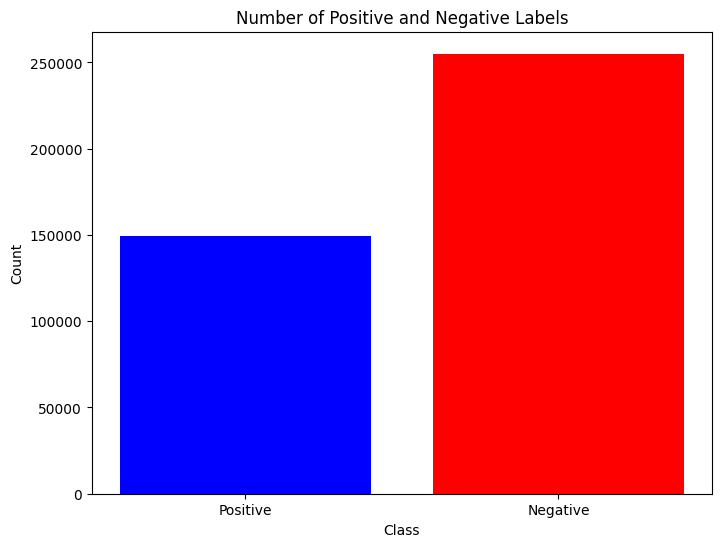

In [35]:
# Count the number of positive and negative labels
pos_count = df['is_duplicate'].sum()
neg_count = len(df) - pos_count
total_count = len(df)

# Print counts
print("Number of positive labels:", pos_count)
print("Number of negative labels:", neg_count)
print("Total number of labels:", total_count)

print("Positive % = ",pos_count/total_count * 100)
print("Negative % = ",neg_count/total_count * 100)
# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Negative'], [pos_count, neg_count], color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Positive and Negative Labels')
plt.show()


### Words for finding similarities

In [36]:
common_words = {

    # Prepositions
    'in', 'on', 'at',
    'of', 'to', 'for', 'with',
    'by', 'from', 'about',
    'into', 'onto', 'upon',
    'within', 'without',

    # Articles
    'a', 'an', 'the',

    # Conjunctions
    'and', 'or', 'but',
    'so', 'yet', 'nor',
    'for',

    # Helping Verbs
    'am', 'is', 'are',
    'was', 'were',
    'be', 'been',
    'have', 'has', 'had',
    'do', 'does', 'did',
    'can', 'could',
    'will', 'would',
    'shall', 'should',
    'may', 'might',
    'must',

    # Common Pronouns
    'i', 'you', 'he', 'she', 'it', 'we', 'they',
    'me', 'him', 'her', 'us', 'them',
    'my', 'your', 'his', 'her', 'its', 'our', 'their',
    'mine', 'yours', 'hers', 'ours', 'theirs',
    'this', 'that', 'these', 'those',

    # Common Adverbs
    'now', 'then',
    'here', 'there',
    'quickly', 'slowly',
    'very', 'too',
    
    # Quantifier
    "all", "some", "any", "no", "few", "many", "several", "much", "most", 
    "more", "less", "little", "a lot of", "a few", "a little", "enough", 
    "lots of", "plenty of", "each", "every", "either", "neither", "both", "none"
}

interogative_words = {"what", "how", "why", "when", "where", "which", "who", "whom", "whose"}

extra_intero_words ={"are", "is", "am", "was", "were", "do", "does", "did", "can", "could",
                      "will", "would", "shall", "should", "have", "has", "had"}
                    

#### Function to find Fuzz ratio - Compare two strings and find their similarities

In [37]:
def unique_word_out(text1,text2,unique_word_set):
    words = re.findall(r'\b\w+\b', text1.lower())
    
    uni_text1 = ""
    for word in words:
        if word in unique_word_set:
            uni_text1+=word+' '
    
    words = re.findall(r'\b\w+\b', text2.lower())
    uni_text2 = ""
    for word in words:
        if word in unique_word_set:
            uni_text2+=word+' '
    
    return fuzz.ratio(uni_text1, uni_text2)

In [38]:
def singularize_words(sentence):
    tokens = word_tokenize(sentence)
    lemmatizer = WordNetLemmatizer()
    singularized_sentence = []

    for word in tokens:
        # Exclude words that are already singular or not nouns or ending with "ing"
        if word.lower() in ["is", "am", "are", "was", "were", "has", "have", "had", "does", "do", "did"]:
            singularized_sentence.append(word)
        else:
            singularized_word = lemmatizer.lemmatize(word)
            singularized_sentence.append(singularized_word)
    return singularized_sentence

#### Function to find features for model

In [45]:


def preprocess_data(text1,text2,output):
    
    q1_cc=0
    q1_uc =0
    q1_ic =0

        
    q2_cc=0
    q2_uc =0
    q2_ic =0

    q1_common = []
    q1_unique = []
    q1_intero = []
    
    
    q2_common = []
    q2_unique = []
    q2_intero = []
    
    text1 = str(text1)
    text2 = str(text2)
    # Remove punctuation and split the text into words
    
    words1 = re.findall(r'\b\w+\b', text1.lower())
    words2 = re.findall(r'\b\w+\b', text2.lower())
    
    str1=""
    str2=""
    for word in words1:
        str1+=word+" "
        
    str1=str1.strip()
    
    for word in words2:
        str2+=word+" "
        
    str2=str2.strip()
    
    words1 = singularize_words(str1)
    words2 = singularize_words(str2)

    # print(words1)
    # print(words2)
    
    # Check if the first word is an extra interrogative word
    if words1 and words1[0] in extra_intero_words:
        q1_intero.append(words1[0])
        words1 = words1[1:]
    
    for word in words1:
        if word in common_words:
            q1_common.append(word)
        elif word in interogative_words:
            q1_intero.append(word)
        else:
            q1_unique.append(word)
  
  
     # Check if the second word is an extra interrogative word
    if words2 and words2[0] in extra_intero_words:
        q2_intero.append(words2[0])
        words2 = words2[1:]
    
    for word in words2:
        if word in common_words:
            q2_common.append(word)
        elif word in interogative_words:
            q2_intero.append(word)
        else:
            q2_unique.append(word)
  
    q1_cl = len(q1_common)
    q1_ul = len(q1_unique)
    q1_il = len(q1_intero)
    
    q2_cl = len(q2_common)
    q2_ul = len(q2_unique)
    q2_il = len(q2_intero)
    
    
    
    tempc = q2_common.copy()
    tempu = q2_unique.copy()
    tempi = q2_intero.copy()
    
    for word in q1_common:
        if word in tempc:
            q1_cc+=1
            tempc.remove(word)
    
    for word in q1_unique:
        if word in tempu:
            q1_uc+=1
            tempu.remove(word)
    
    for word in q1_intero:
        if word in tempi:
            q1_ic+=1
            tempi.remove(word)
    
    
    tempc = q1_common.copy()
    tempu = q1_unique.copy()
    tempi = q1_intero.copy()

    for word in q2_common:
        if word in tempc:
            q2_cc+=1
            tempc.remove(word)
    
    for word in q2_unique:
        if word in tempu:
            q2_uc+=1
            tempu.remove(word)
    
    for word in q2_intero:
        if word in tempi:
            q2_ic+=1
            tempi.remove(word)
            
    unique_set = set()
    
    
    for word in q1_unique:
        unique_set.add(word)
    
    for word in q2_unique:
        unique_set.add(word)
    
    fuzzy_ratio=unique_word_out(text1,text2,unique_set)
    
    if(q1_cl==0):
        q1_cl=1
    if(q1_ul==0):
        q1_ul=1
    if(q1_il==0):
        q1_il=1
    if(q2_cl==0):
        q2_cl=1
    if(q2_ul==0):
        q2_ul=1
    if(q2_il==0):
        q2_il=1

    return q1_cc/q1_cl,q1_uc/q1_ul,q1_ic/q1_il,q2_cc/q2_cl,q2_uc/q2_ul,q2_ic/q2_il,fuzzy_ratio/100.0,output


##### Processing each string and storing features

In [47]:
features_list = []
label = []
for index, row in df.iterrows():
    question1 = row["question1"]
    question2 = row["question2"]
    output = row["is_duplicate"]
    features = preprocess_data(question1, question2,output)
    features_list.append(features)

In [48]:
features_df = pd.DataFrame(features_list,columns=["q1_c","q1_u","q1_i", "q2_c","q2_u","q2_i","fuzzy_ratio","label"])

In [49]:
for i in range(0,10):
    print(features_list[i])
    

(0.8333333333333334, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 0.92, 0)
(0.5, 0.8, 1.0, 0.5, 0.4, 1.0, 0.62, 0)
(0.16666666666666666, 0.2857142857142857, 1.0, 0.3333333333333333, 0.3333333333333333, 1.0, 0.54, 0)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24, 0)
(0.5, 0.2, 1.0, 0.5, 0.5, 1.0, 0.38, 0)
(0.75, 0.5, 1.0, 0.75, 0.5, 1.0, 0.68, 1)
(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.29, 0)
(0.75, 0.5, 0.0, 0.5, 0.5, 0.0, 0.77, 1)
(1.0, 0.5, 1.0, 0.75, 1.0, 1.0, 0.86, 0)
(0.3333333333333333, 0.5, 0.0, 0.3333333333333333, 0.6, 0.0, 0.52, 0)


In [50]:
features_df.to_csv('data/features2.csv', index=False)

In [5]:
features_df = pd.read_csv('data/features2.csv')

# Separate features and labels
x_train = features_df.drop('label', axis=1).values  # Exclude the 'label' column
y_train = features_df['label']


# Optionally, you can convert y_train to a numpy array if needed
y_train = y_train.values

In [29]:
import numpy as np

In [32]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [33]:
print(type(x_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [34]:
for i in range(0,10):
    print(x_train[i],"\t",y_train[i])

[0.         0.33333333 0.         0.         0.66666667 0.
 0.48      ] 	 0
[0.6        0.625      0.         0.42857143 0.71428571 0.
 0.77      ] 	 0
[0.33333333 0.33333333 0.         0.16666667 0.4        0.
 0.47      ] 	 0
[1.   0.8  1.   1.   0.8  1.   0.99] 	 1
[0.25       0.4        0.         0.33333333 0.66666667 0.
 0.79      ] 	 1
[0.         0.5        0.         0.         0.16666667 0.
 0.57      ] 	 0
[0.75       1.         1.         1.         0.66666667 1.
 0.78      ] 	 1
[1.   0.75 1.   1.   0.75 1.   0.56] 	 1
[1.   0.75 1.   1.   0.75 1.   0.66] 	 0
[0.75 0.5  1.   1.   0.75 1.   0.68] 	 0


##### Spliting the data for training and testing

In [35]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

In [36]:
print(type(x_test))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#### Using GridSearch to find best parameters 

In [18]:
# params = { 'max_depth': [6,8,10],
#            'learning_rate': [0.01, 0.05, 0.1],
#            'n_estimators': [300, 500, 800],
#            'colsample_bytree': [0.5, 0.7,0.9],
#            'subsample': [0.6,0.8]}
# xgbr = xgb.XGBClassifier(random_state=42,device="cuda")
# clf = GridSearchCV(estimator=xgbr, 
#                    param_grid=params,
#                    scoring='accuracy', 
#                    verbose=1)
# clf.fit(x_train, y_train)
# print("Best parameters:", clf.best_params_)
# print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

##### Training the model on our parameters

In [37]:
# Train the model
num_rounds = 1000
#classifier = XGBClassifier(eta=0.01, device="cuda", max_depth=10,subsample= 0.6, colsample_bytree= 0.9,n_estimators=num_rounds)
classifier = XGBClassifier(eta=0.01, max_depth=10,subsample= 0.6, colsample_bytree= 0.9,n_estimators=num_rounds)
# Train the model
#model = classifier.fit(cp.array(x_train), y_train)
model = classifier.fit(x_train, y_train)

##### Printing the Classification Report

In [38]:
predictions = model.predict(x_test)
classification = classification_report(y_test, predictions)
print(classification)

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     32795
           1       0.62      0.65      0.64     18954

    accuracy                           0.73     51749
   macro avg       0.71      0.71      0.71     51749
weighted avg       0.73      0.73      0.73     51749



Accuracy: 0.7280541195676371
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78     50985
           1       0.63      0.65      0.64     29873

    accuracy                           0.73     80858
   macro avg       0.71      0.71      0.71     80858
weighted avg       0.73      0.73      0.73     80858



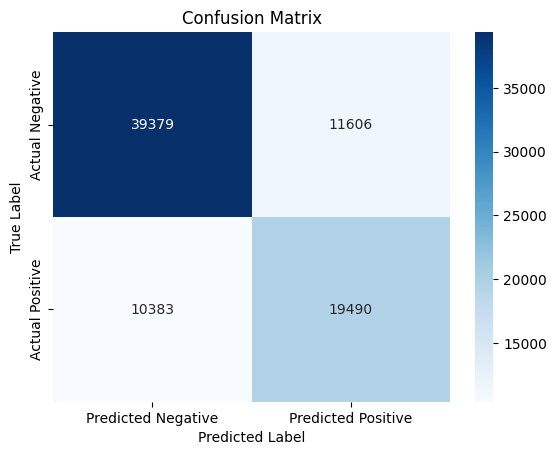

In [18]:
# Make predictions on the test data
y_pred = model.predict(x_test)
y_pred_binary = [1 if pred > 0.6 else 0 for pred in y_pred]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [39]:
# Save the model
joblib.dump(model, 'xgboost_model1.pkl')

['xgboost_model1.pkl']